**Task**: realize CAMNS to solve BSS (or simply "a lot of frightful abbreviation to scare the reader")
In human terms: We have observations to be separated into source signals. For this purpose we have to find mixing matrix. \
The CAMNS works properly under the list of assumptions:


1.   Each source is non-negative
2.   In each observation there have to be a dominant source
1.   Sum of each row of mixing matrix should to be equal to 1
2.   Dimension of observations must be at least equal to dimension of sources





A little bit of imports

In [27]:
from cvxpy import Variable, Problem, Minimize, Maximize
from cvxopt import solvers, matrix
solvers.options['show_progress'] = False
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

The reason we all gathered togethere today

In [28]:
class Solver:
    def __init__(self):
        self.C = None
        self.d = None

    def camns_lp(self, X, N, tol_lp=1e-3, tol_ext=1e-6):
        X = X.T
        L, M = X.shape

        self.d = np.mean(X, axis=1)
        self.C = np.linalg.svd(X - np.expand_dims(self.d, axis=1), full_matrices=False)[0][:, :N-1]

        Q1 = np.eye(L)
        S = np.zeros((0, L))

        loops = 0

        l = 0
        while l < N:
            loops += 1 

            w = sps.norm.rvs(size=L)
            r = Q1.dot(w)

            p_star, a_1, v_1 = self.conv_opt_prob(r, is_min=True)
            q_star, a_2, v_2 = self.conv_opt_prob(r, is_min=False)

            if l == 0:
                if self.is_ext_pt(a_1, tol_ext):
                    S = np.append(S, [v_1.squeeze()], axis=0)
                    
                if self.is_ext_pt(a_2, tol_ext):
                    S = np.append(S, [v_2.squeeze()], axis=0)
            
            else:
                if (p_star / np.linalg.norm(r) / np.linalg.norm(v_1) >= tol_lp) \
                    and self.is_ext_pt(a_1, tol_ext):
                    S = np.append(S, [v_1.squeeze()], axis=0)
                
                if (q_star / np.linalg.norm(r) / np.linalg.norm(v_2) >= tol_lp) \
                    and self.is_ext_pt(a_2, tol_ext):
                    S = np.append(S, [v_2.squeeze()], axis=0)

            l = S.shape[0]
            
            Q = np.linalg.qr(S.T)[0]
            Q1 = np.eye(L) - Q.dot(Q.T)
        
        print(f'Total loops: {loops}')
        
        return S

    def conv_opt_prob(self, r, is_min):
        Task = Minimize if is_min else Maximize
        alpha = Variable(self.C.shape[1])
        problem = Problem(Task(r.T @ (self.C @ alpha + self.d)), [self.C @ alpha + self.d >= 0])
        s = problem.solve(solver='ECOS_BB')
        return s, alpha.value, self.C @ alpha.value + self.d


    def is_ext_pt(self, alpha, tol):
        D = self.C.shape[1]
        T = self.C[np.all(np.abs(np.expand_dims(self.C.dot(alpha) + self.d, axis=1)) < tol, axis=1), :]
        ran = np.linalg.matrix_rank(T, tol=tol)
        return T.shape[0] != 0 or ran == D

Uninteresting load of images

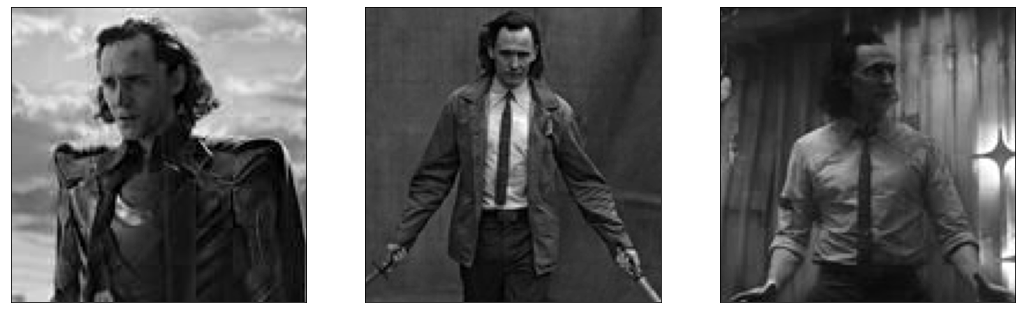

In [29]:
def img_to_arr(img_path):
    img = plt.imread(img_path)
    
    if len(img.shape) > 2:
        img = img[:, :, 2]
    
    img.astype(np.float64)/255.0
    return img.reshape(128*128)

def plot_imgs(imgs, img_size=6):
    n = len(imgs)
    fig, axs = plt.subplots(1, n, figsize=(img_size * n, img_size))

    for ax, img in zip(axs, imgs):
        i2d = img.reshape(128, 128)
        ax.imshow(i2d, cmap=plt.cm.gray)
        ax.set_xticks([])
        ax.set_yticks([])

photos_count = 3
paths = [*map(lambda n: f'./{n}.jpg', range(photos_count))]
imgs = [*map(img_to_arr, paths)]

plot_imgs(imgs)

Let's do the trick on the greatest trixter of MCU

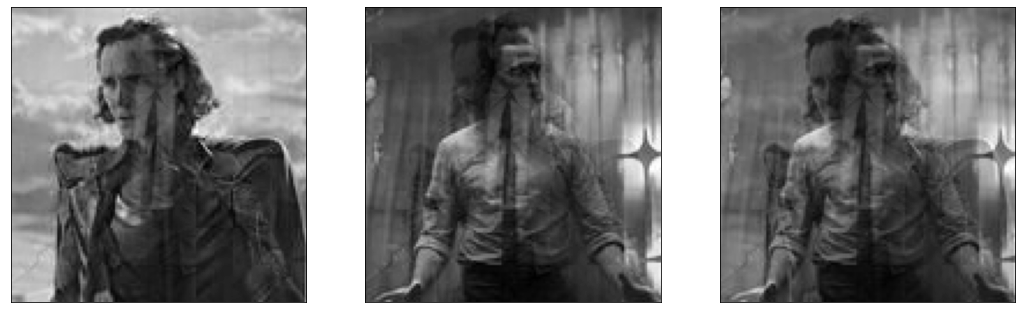

In [30]:
s = np.random.rand(photos_count, photos_count)
mix_matrix = s / np.sum(s, axis=1, keepdims=True)

X = mix_matrix.dot(imgs)
plot_imgs(X)

Now Mobius M. Mobius needs our help to separate 3 variants of Loki. Let's help him!

Total loops: 3


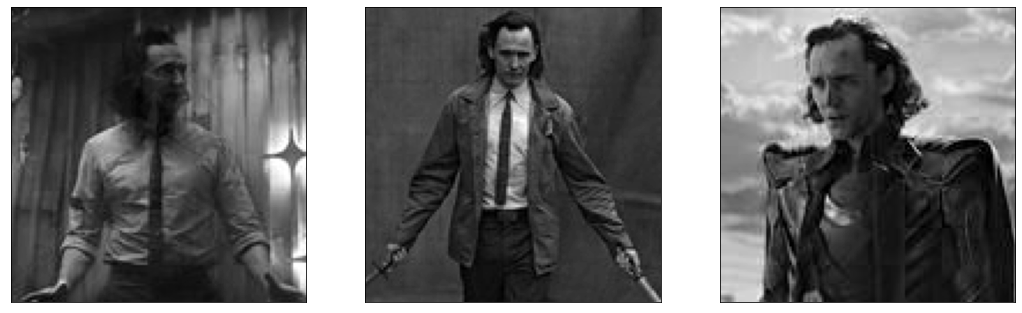

In [32]:
S = Solver()
solved = S.camns_lp(X, photos_count)
plot_imgs(solved)

When the work is done Mobius finally can prune each of the variants. The sacred timeline is safe. For all time. Always!